# Assignment: Linear Models
## Foundations of Machine Learning
## Do Q1 and one other question

**Q0.** Please answer the following questions in your own words.

1. What makes a model "linear"? "Linear" in what?
2. How do you interpret the coefficient for a dummy/one-hot-encoded variable? (This is a trick question, and the trick involves how you handle the intercept of the model.)
3. Can linear regression be used for classification? Explain why, or why not.
4. What are signs that your linear model is over-fitting?
5. Clearly explain multi-colinearity using the two-stage least squares technique.
6. What are two ways to incorporate nonlinear relationships between your target/response/dependent/outcome variable $y$ and your features/control/response/independent variables $x$?
7. What is the interpretation of the intercept? A slope coefficient for a variable? The coefficient for a dummy/one-hot-encoded variable?

**Q1.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/willmayer/Desktop/DS3001/ds3001-linearRegression/data/Q1_clean.csv',low_memory=False)

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.

In [73]:
df = df.rename(columns={'Neighbourhood ':'Neighbourhood'})

In [74]:
print(df.groupby('Neighbourhood')['Price'].mean().sort_values(ascending=False),'\n')
print(df.groupby('Neighbourhood')['Review Scores Rating'].mean().sort_values(ascending=False))

Neighbourhood
Manhattan        183.664286
Staten Island    146.166667
Brooklyn         127.747378
Queens            96.857233
Bronx             75.276498
Name: Price, dtype: float64 

Neighbourhood
Brooklyn         92.363497
Manhattan        91.801496
Bronx            91.654378
Queens           91.549057
Staten Island    90.843750
Name: Review Scores Rating, dtype: float64


*Manhattan is the most expensive on average with price $183.66*

<Axes: xlabel='Price', ylabel='Density'>

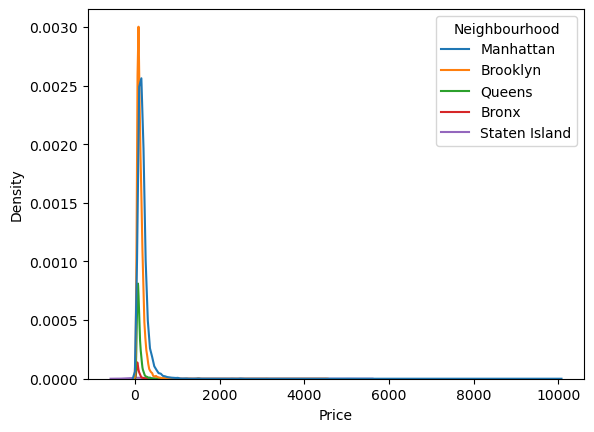

In [75]:
sns.kdeplot(df, x='Price', hue='Neighbourhood')

<Axes: xlabel='pricex', ylabel='Density'>

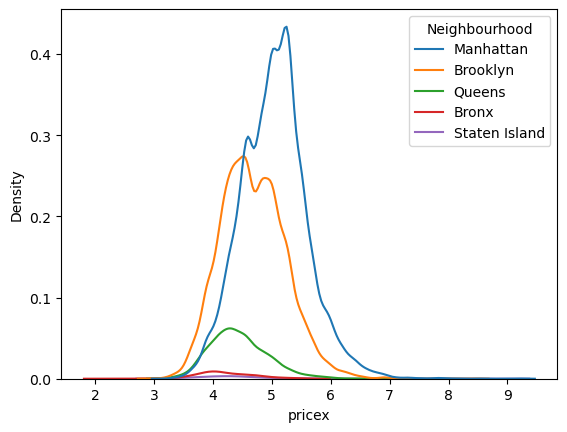

In [76]:
df['pricex'] = np.log(df['Price'])
sns.kdeplot(df, x='pricex', hue='Neighbourhood')

2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?

In [77]:
import sklearn.linear_model

y = df['Price']
X = pd.get_dummies(df['Neighbourhood'], dtype=int)

model = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(X, y)

results = {'Neighbourhood': X.columns, 'Coefficient': model.coef_}
pd.DataFrame(results)

,Neighbourhood,Coefficient
0,Bronx,75.276498
1,Brooklyn,127.747378
2,Manhattan,183.664286
3,Queens,96.857233
4,Staten Island,146.166667


*The coefficients are the same as the average prices for each neighbourhood. Because you're regressing price only based on neighborhood information, the model weights each prediction with all the information it has on the relationship between neighbourhood and price.*

3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?

In [78]:
X = pd.get_dummies(df['Neighbourhood'], drop_first=True, dtype=int)
model = sklearn.linear_model.LinearRegression().fit(X, y)
results = {'Neigbourhood: ': X.columns, 'Coefficient: ': model.coef_}
pd.DataFrame(results)

,Neigbourhood:,Coefficient:
0,Brooklyn,52.470881
1,Manhattan,108.387789
2,Queens,21.580735
3,Staten Island,70.890169


*We've made the Bronx the intercept, so each coefficient is now the average increase in price for each neighbourhood relative to average price in the Bronx. For example, living in Manhaattan means you pay an average $108 higher than in the Bronx. To get the coefficient from part 2, you add the average price of the Bronx, or the Bronx's coefficient from step 2. The intercept of the model is the smae as the original coefficient for the Bronx from part 2.*

In [79]:
model.intercept_

75.2764976958471

4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?

In [80]:
import sklearn.model_selection

y = df['Price']
X = df.loc[:,['Review Scores Rating', 'Neighbourhood']]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.2, random_state=100)

train_dummies = pd.get_dummies(X_train['Neighbourhood'], dtype='int')
test_dummies = pd.get_dummies(X_test['Neighbourhood'], dtype='int')

Z_train = pd.concat([X_train['Review Scores Rating'], train_dummies], axis=1)
Z_test = pd.concat([X_test['Review Scores Rating'], test_dummies], axis=1)

In [81]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
fitted = model.fit(Z_train, y_train)

y_hat = fitted.predict(Z_test)
print('R-squared:', fitted.score(Z_test, y_test))
rmse = np.sqrt(np.mean((y_test - y_hat)**2))
print('RMSE:', rmse)
results = {'Variable': fitted.feature_names_in_, 'Coefficient': fitted.coef_}
pd.DataFrame(results)

R-squared: 0.06701086106947252
RMSE: 125.01092061382934


,Variable,Coefficient
0,Review Scores Rating,1.032257
1,Bronx,-17.261392
2,Brooklyn,32.180888
3,Manhattan,89.421020
4,Queens,4.050208
5,Staten Island,61.576393


*Each point increase in rating is associataed with an average price increase of 1.03. The most expensive apartment you could rent is a top-rated (100/100) place in Manhattan*

In [82]:
print('Most expensive place:', np.round(100*1.032257 + 89.421020,2))

Most expensive place: 192.65


5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Room Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?

In [83]:
y = df['Price']
X = df.loc[:, ['Review Scores Rating','Neighbourhood','Room Type']]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.2, random_state=100)


Z_train = pd.concat([
    X_train['Review Scores Rating'],
    pd.get_dummies(X_train['Neighbourhood'],dtype='int'),
    pd.get_dummies(X_train['Room Type'], dtype='int')],
    axis=1
)

Z_test = pd.concat([
    X_test['Review Scores Rating'],
    pd.get_dummies(X_test['Neighbourhood'],dtype='int'),
    pd.get_dummies(X_test['Room Type'],dtype='int')],
    axis=1
)

model = sklearn.linear_model.LinearRegression(fit_intercept=False)
fitted = model.fit(Z_train, y_train)
y_hat = fitted.predict(Z_test)
print('R-squared:', fitted.score(Z_test, y_test))
rmse = np.sqrt(np.mean((y_test-y_hat)**2))
print('RMSE:', rmse)
results = {'Variable':fitted.feature_names_in_, 'Coefficient': fitted.coef_}
pd.DataFrame(results)

R-squared: 0.2203534812928234
RMSE: 114.27692123130632


,Variable,Coefficient
0,Review Scores Rating,0.626912
1,Bronx,-13.022765
2,Brooklyn,10.378456
3,Manhattan,53.693304
4,Queens,-6.833330
5,Staten Island,50.003022
6,Entire home/apt,110.617820
7,Private room,3.101341
8,Shared room,-19.500474


*Now that we've added the home type, the review scores rating is less strong of a predictor, indicating score could have masked variance in room type. The new most expensive house is a 100-rated entire home/apt in Manhattan, but the location and rating now contirbute less to the average increase.*

In [84]:
print('Most expensive: place', np.round(0.626912*100 + 110.617820 + 53.693304, 2 ))

Most expensive: place 227.0


6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.

*Like I mentioned above, score might be an endogenous variable to room type and price (it could be correlated possitively both with better room types and higher prices.) In the earlier model, without considering room type, variance in price was attributed to ratings increases. However, considering both ratings and room type, room type is the stronger predictor. Because room rating and type are correlated, variance in price was understood to be caused by variance in rating, but it was actually variance in room type.*

7. (Optional) We've included `Neighborhood ` and `Room Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A shared room in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they change significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent? 

In [85]:
y = df['Price']
df['nXrt'] = df['Neighbourhood'] + ': ' + df['Room Type']
X = df.loc[:,['Review Scores Rating', 'nXrt']]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.2, random_state=100)


Z_train = pd.concat([
    X_train['Review Scores Rating'],
    pd.get_dummies(X_train['nXrt'], dtype='int')],
    axis=1
)

Z_test = pd.concat([
    X_test['Review Scores Rating'],
    pd.get_dummies(X_test['nXrt'], dtype='int')],
    axis=1
)

model = sklearn.linear_model.LinearRegression(fit_intercept=False)
fitted = model.fit(Z_train, y_train)
y_hat = fitted.predict(Z_test)
print('R-squared:', fitted.score(Z_test, y_test))
rmse = np.sqrt(np.mean((y_test-y_hat)**2))
print('RMSE:', rmse)
results = {'Variable':fitted.feature_names_in_, 'Coefficient':model.coef_}
pd.DataFrame(results)

R-squared: 0.2227250747073216
RMSE: 114.1029803472431


,Variable,Coefficient
0,Review Scores Rating,0.631849
1,Bronx: Entire home/apt,63.133021
2,Bronx: Private room,3.736301
3,Bronx: Shared room,-21.278036
4,Brooklyn: Entire home/apt,113.784926
5,Brooklyn: Private room,20.579025
6,Brooklyn: Shared room,-3.210858
7,Manhattan: Entire home/apt,169.494389
8,Manhattan: Private room,45.531833
9,Manhattan: Shared room,24.553861


**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

<Axes: >

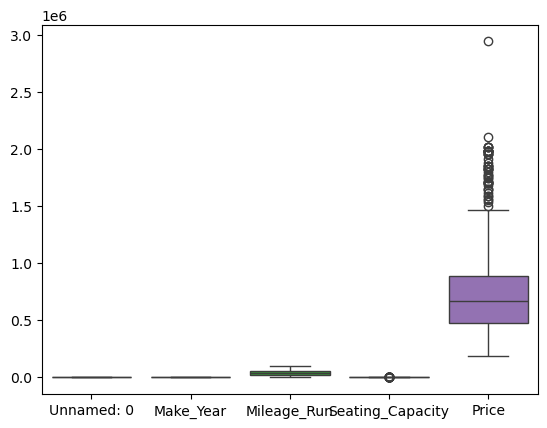

In [86]:
df = pd.read_csv('/Users/willmayer/Desktop/DS3001/ds3001-linearRegression/data/cars_hw.csv', low_memory=False)
sns.boxplot(df)

*Many outliers in price*

In [87]:
df.columns

Index(['Unnamed: 0', 'Make', 'Make_Year', 'Color', 'Body_Type', 'Mileage_Run',
       'No_of_Owners', 'Seating_Capacity', 'Fuel_Type', 'Transmission',
       'Transmission_Type', 'Price'],
      dtype='object')

<Axes: ylabel='Mileage_Run'>

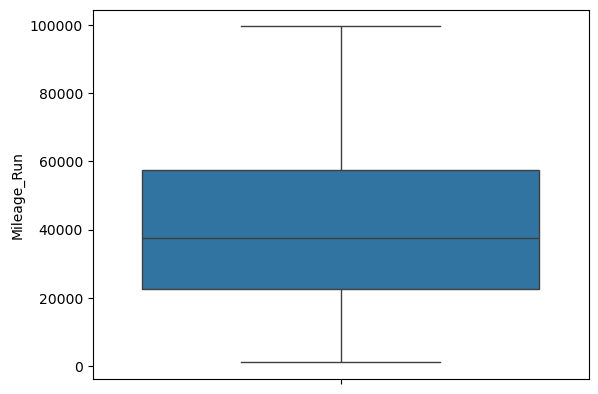

In [88]:
sns.boxplot(df['Mileage_Run'])

<Axes: ylabel='Price'>

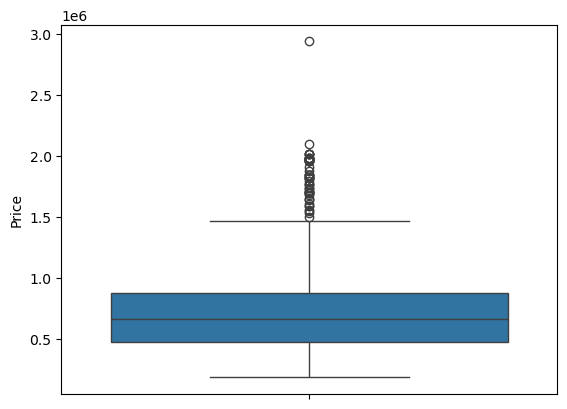

In [89]:
sns.boxplot(df['Price'])

In [90]:
df['price_adj'] = np.arcsinh(df['Price'])
df['mileage_adj'] = np.arcsinh(df['Mileage_Run'])
df['age'] = max(df['Make_Year']) - df['Make_Year']
df = df.loc[:, ['Make', 'age', 'Color', 'Body_Type', 'price_adj', 'mileage_adj', 'No_of_Owners', 'Seating_Capacity',
                'Fuel_Type', 'Transmission', 'Transmission_Type']]

<Axes: >

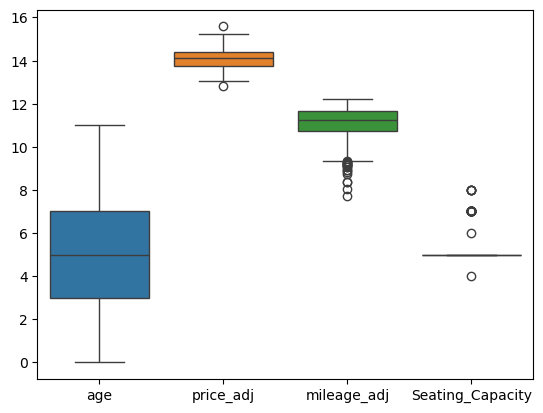

In [91]:
sns.boxplot(df)

  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?

*Inverse hyperbolic sine prices*

In [92]:
df['price_adj'].describe()

count    976.000000
mean      14.104181
std        0.450276
min       12.837344
25%       13.765795
50%       14.102942
75%       14.384228
max       15.587407
Name: price_adj, dtype: float64

In [93]:
df['price_adj'].groupby(df['Make']).describe()

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,13.613042,0.480975,13.188151,13.261539,13.445433,13.864828,14.394369
Datsun,3.0,13.269194,0.036311,13.232114,13.251449,13.270783,13.287734,13.304685
Ford,52.0,14.161427,0.210895,13.270783,14.054527,14.162640,14.269131,14.572571
Honda,73.0,14.229465,0.336972,13.356645,13.965653,14.266586,14.419827,14.938490
Hyundai,305.0,14.061658,0.398781,13.114331,13.785051,14.059241,14.330727,15.063692
Jeep,4.0,14.909738,0.105084,14.763300,14.876417,14.933413,14.966733,15.008827
Kia,8.0,14.985324,0.076877,14.822738,14.965389,14.996253,15.042662,15.063117
MG Motors,35.0,15.132199,0.066263,14.971763,15.088892,15.122762,15.190744,15.211260
Mahindra,18.0,14.592100,0.159906,14.280502,14.544955,14.598828,14.654396,14.890513


<Axes: xlabel='price_adj', ylabel='Density'>

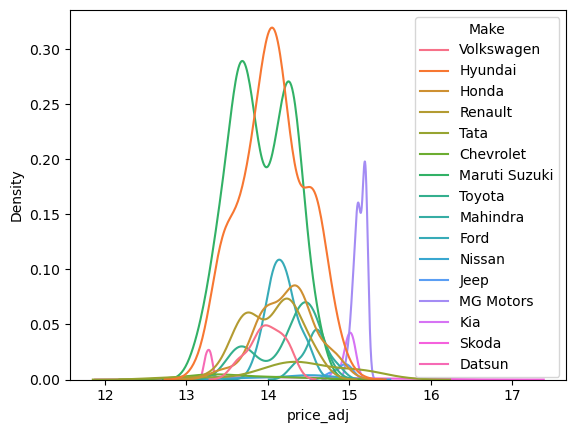

In [94]:
sns.kdeplot(df, x='price_adj', hue='Make')

*MG Motors, KIA, and Jeep all have average (scaled) prices above 14.9. Most car makes follow a normal-ish distribution with about one max. Skoda and Tata have more variance of price within released models. Different makes are less separated by price than I would imagine--most makes seem to have a decent spread of different price points*

  3. Split the data into an 80% training set and a 20% testing set.

In [108]:
N = df.shape[0]
df = df.sample(frac = 1)
train_size = int(0.8 * N)

df_train = df[0:train_size]
y_train = df_train['price_adj']

df_test = df[train_size:]
y_test = df_test['price_adj']

  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?

In [109]:
from sklearn import model_selection
from sklearn import linear_model

# Numeric variables only

X_train_n = df_train.loc[:, ['age','mileage_adj','Seating_Capacity']]
model = linear_model.LinearRegression().fit(X_train_n, y_train)
X_test_n = df_test.loc[:,['age','mileage_adj','Seating_Capacity']]
y_hat = model.predict(X_test_n)
print('Numeric r-squared:', model.score(X_test_n, y_test))
rmse = np.sqrt(np.mean((y_test - y_hat)**2))
print('Numeric rmse:', rmse)

Numeric r-squared: 0.4172864171206907
Numeric rmse: 0.3541269610921778


In [107]:
# Categorical Variables only

y = df['price_adj']
cats = ['Make', 'Body_Type', 'Color', 'Fuel_Type', 'Transmission', 'Transmission_Type']
X = df.loc[:,cats]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

dummies = []

Z_train = pd.DataFrame([])

for i in X_train.columns:
    dummies.append(pd.get_dummies(df.loc[:,i], drop_first=True, dtype='int'))

for i in cats:


# dummies = []

# Z_train = pd.DataFrame([])
# Z_test 

# for i in cats:
#     n = pd.get_dummies(df.loc[:, i], drop_first=True, dtype='int')
#     dummies.append(n)



IndentationError: expected an indented block (121607159.py, line 27)

**Q3.** This is a question about linear regression. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running the following regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q4.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{alignat*}{3}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{alignat*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{alignat*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{alignat*}

which can be written in terms of sample covariance and sample variance as:

\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{alignat*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)

**Q5.**
1. Find a dataset on a topic you're interested in. Some easy options are data.gov, kaggle.com, and data.world.
2. Clean the data and do some exploratory data analysis on key variables that interest you. Pick a particular target/outcome variable and features/predictors.
3. Split the sample into an ~80% training set and a ~20% test set.
4. Run a few regressions of your target/outcome variable on a variety of features/predictors. Compute the SSE on the test set.
5. Which model performed the best, and why?
6. What did you learn?